In [33]:
#INSTALLATIONS AND INITIALISATION

In [12]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    !pip install ucimlrepo
    from ucimlrepo import fetch_ucirepo

adult = fetch_ucirepo(id=2)
X_df = adult.data.features
y_df = adult.data.targets


In [34]:
#TRAIN TEST SPLIT

In [13]:
full_df = pd.concat([X_df, y_df], axis=1)
full_df.replace('?', np.nan, inplace=True)
full_df.dropna(inplace=True)

X = full_df.iloc[:, :-1]
y = full_df.iloc[:, -1]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category').cat.codes

y = y.apply(lambda x: 1 if x in ['>50K', '>50K.'] else 0)

feature_names = X.columns.tolist()

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

X_train, y_train = X_train.values, y_train.values
X_val, y_val = X_val.values, y_val.values
X_test, y_test = X_test.values, y_test.values

print("Data preparation complete.")
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Data preparation complete.
Training set shape: (27133, 14)
Validation set shape: (9044, 14)
Test set shape: (9045, 14)


In [35]:
#TREE FROM SCRATCH

In [19]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=100, criterion='gini'):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.criterion = criterion
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Check for stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or \
           (n_labels == 1) or \
           (n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, n_features, replace=False)
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        if best_feat is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_impurity = self._calculate_impurity(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._calculate_impurity(y[left_idxs]), self._calculate_impurity(y[right_idxs])
        child_impurity = (n_l / n) * e_l + (n_r / n) * e_r
        return parent_impurity - child_impurity

    def _calculate_impurity(self, y):
        if self.criterion == 'gini':
            return self._gini(y)
        elif self.criterion == 'entropy':
            return self._entropy(y)

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _gini(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return 1 - np.sum(ps**2)

    def _most_common_label(self, y):
        counter = Counter(y)
        if not counter:
            return 0
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

print("Decision Tree classes defined.")



Decision Tree classes defined.


In [36]:
#DEFINING EVAL METRICS FROM SCRATCH

In [20]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def confusion_matrix(y_true, y_pred):
    cm = np.zeros((2, 2), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1
    return cm

def precision(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fn = cm[1, 0]
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r) if (p + r) > 0 else 0

print("Evaluation metrics defined.")


Evaluation metrics defined.


In [37]:
#GINI VS ENTROPY

In [21]:
gini_tree = DecisionTreeClassifier(max_depth=10, criterion='gini')
gini_tree.fit(X_train, y_train)
y_pred_gini = gini_tree.predict(X_test)

entropy_tree = DecisionTreeClassifier(max_depth=10, criterion='entropy')
entropy_tree.fit(X_train, y_train)
y_pred_entropy = entropy_tree.predict(X_test)

print("--- Gini Impurity Results (Test Set) ---")
print(f"Accuracy: {accuracy(y_test, y_pred_gini):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_gini):.4f}")
print()
print("--- Entropy Results (Test Set) ---")
print(f"Accuracy: {accuracy(y_test, y_pred_entropy):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_entropy):.4f}")


--- Gini Impurity Results (Test Set) ---
Accuracy: 0.8483
F1-Score: 0.6735

--- Entropy Results (Test Set) ---
Accuracy: 0.8482
F1-Score: 0.6353


In [39]:
#COMPARE VARIOUS DEPTHS &&& PRE - PRUNING

In [22]:
depths = [2, 4, 6, 8, 10, None]
val_accuracies = []

for depth in depths:
    max_d = depth if depth is not None else 'Unlimited'
    tree = DecisionTreeClassifier(max_depth=depth, min_samples_split=5)
    tree.fit(X_train, y_train)
    y_val_pred = tree.predict(X_val)
    acc = accuracy(y_val, y_val_pred)
    val_accuracies.append(acc)
    print(f"Depth: {max_d}, Validation Accuracy: {acc:.4f}")

best_depth_idx = np.argmax(val_accuracies)
best_depth = depths[best_depth_idx]
print(f"\nBest depth found: {best_depth if best_depth else 'Unlimited'}")

best_pre_pruned_tree = DecisionTreeClassifier(max_depth=best_depth, min_samples_split=5)
best_pre_pruned_tree.fit(X_train, y_train)
y_test_pred_prepruned = best_pre_pruned_tree.predict(X_test)

print("\n--- Best Pre-Pruned Tree Results (Test Set) ---")
print(f"Accuracy: {accuracy(y_test, y_test_pred_prepruned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_prepruned):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_prepruned))


Depth: 2, Validation Accuracy: 0.8205
Depth: 4, Validation Accuracy: 0.8383
Depth: 6, Validation Accuracy: 0.8479
Depth: 8, Validation Accuracy: 0.8485
Depth: 10, Validation Accuracy: 0.8446
Depth: Unlimited, Validation Accuracy: 0.8051

Best depth found: 8

--- Best Pre-Pruned Tree Results (Test Set) ---
Accuracy: 0.8486
F1-Score: 0.6358
Confusion Matrix:
 [[6481  322]
 [1047 1195]]


In [40]:
#POST PRUNING

In [23]:
import copy

def _prune_recursive(tree, node, X, y):
    if node.is_leaf_node():
        return

    left_idxs, right_idxs = tree._split(X[:, node.feature], node.threshold)
    X_left, y_left = X[left_idxs], y[left_idxs]
    X_right, y_right = X[right_idxs], y[right_idxs]

    if node.left and len(y_left) > 0:
        _prune_recursive(tree, node.left, X_left, y_left)
    if node.right and len(y_right) > 0:
        _prune_recursive(tree, node.right, X_right, y_right)

    if not node.left.is_leaf_node() or not node.right.is_leaf_node():
        return

    acc_before_prune = accuracy(y, tree.predict(X))

    original_left = node.left
    original_right = node.right
    node.left = None
    node.right = None
    node.value = tree._most_common_label(y)

    acc_after_prune = accuracy(y, tree.predict(X))

    if acc_after_prune < acc_before_prune:
        node.left = original_left
        node.right = original_right
        node.value = None

full_tree = DecisionTreeClassifier(max_depth=None, min_samples_split=5)
full_tree.fit(X_train, y_train)

post_pruned_tree = copy.deepcopy(full_tree)
_prune_recursive(post_pruned_tree, post_pruned_tree.root, X_val, y_val)

y_test_pred_postpruned = post_pruned_tree.predict(X_test)

print("--- Post-Pruned Tree Results (Test Set) ---")
print(f"Accuracy: {accuracy(y_test, y_test_pred_postpruned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_postpruned):.4f}")


--- Post-Pruned Tree Results (Test Set) ---
Accuracy: 0.8304
F1-Score: 0.6389


In [41]:
#UNPRUNED VS PRE PRUNNED VS POST PRUNNED

In [24]:
y_pred_full = full_tree.predict(X_test)
full_tree_accuracy = accuracy(y_test, y_pred_full)

print("--- Tree Performance Comparison on Test Set ---")
print(f"Full Unpruned Tree Accuracy:    {full_tree_accuracy:.4f}")
print(f"Best Pre-Pruned Tree Accuracy:  {accuracy(y_test, y_test_pred_prepruned):.4f}")
print(f"Post-Pruned Tree Accuracy:    {accuracy(y_test, y_test_pred_postpruned):.4f}")


--- Tree Performance Comparison on Test Set ---
Full Unpruned Tree Accuracy:    0.8082
Best Pre-Pruned Tree Accuracy:  0.8486
Post-Pruned Tree Accuracy:    0.8304


In [42]:
#MOST IMPORTANT FEATURES

In [25]:
root_node = best_pre_pruned_tree.root
root_feature_index = root_node.feature
root_feature_name = feature_names[root_feature_index]
root_threshold = root_node.threshold

print("--- Feature Importance ---")
print(f"The first split is on the feature: '{root_feature_name}'")
print(f"The threshold for the split is: {root_threshold}")


--- Feature Importance ---
The first split is on the feature: 'relationship'
The threshold for the split is: 0


In [43]:
#SICKIT LEARN TREE VS HARD CODED

In [26]:
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTree
from sklearn.metrics import accuracy_score, f1_score as sklearn_f1

sklearn_tree = SklearnDecisionTree(max_depth=best_depth, min_samples_split=5, random_state=42)
sklearn_tree.fit(X_train, y_train)

y_pred_sklearn = sklearn_tree.predict(X_test)

print("--- Scikit-learn Decision Tree Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_sklearn):.4f}")
print(f"F1-Score: {sklearn_f1(y_test, y_pred_sklearn):.4f}")
print()
print("--- My Implementation (Best Pre-Pruned) ---")
print(f"Accuracy: {accuracy(y_test, y_test_pred_prepruned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_prepruned):.4f}")


--- Scikit-learn Decision Tree Results ---
Accuracy: 0.8494
F1-Score: 0.6376

--- My Implementation (Best Pre-Pruned) ---
Accuracy: 0.8486
F1-Score: 0.6358


In [32]:
#SICKIT LLEARN TREE

--- Scikit-learn Decision Tree Results ---
Accuracy: 0.8494
F1-Score: 0.6376

--- My Implementation (Best Pre-Pruned) ---
Accuracy: 0.8486
F1-Score: 0.6358

--- Visualizing the Scikit-learn Decision Tree ---


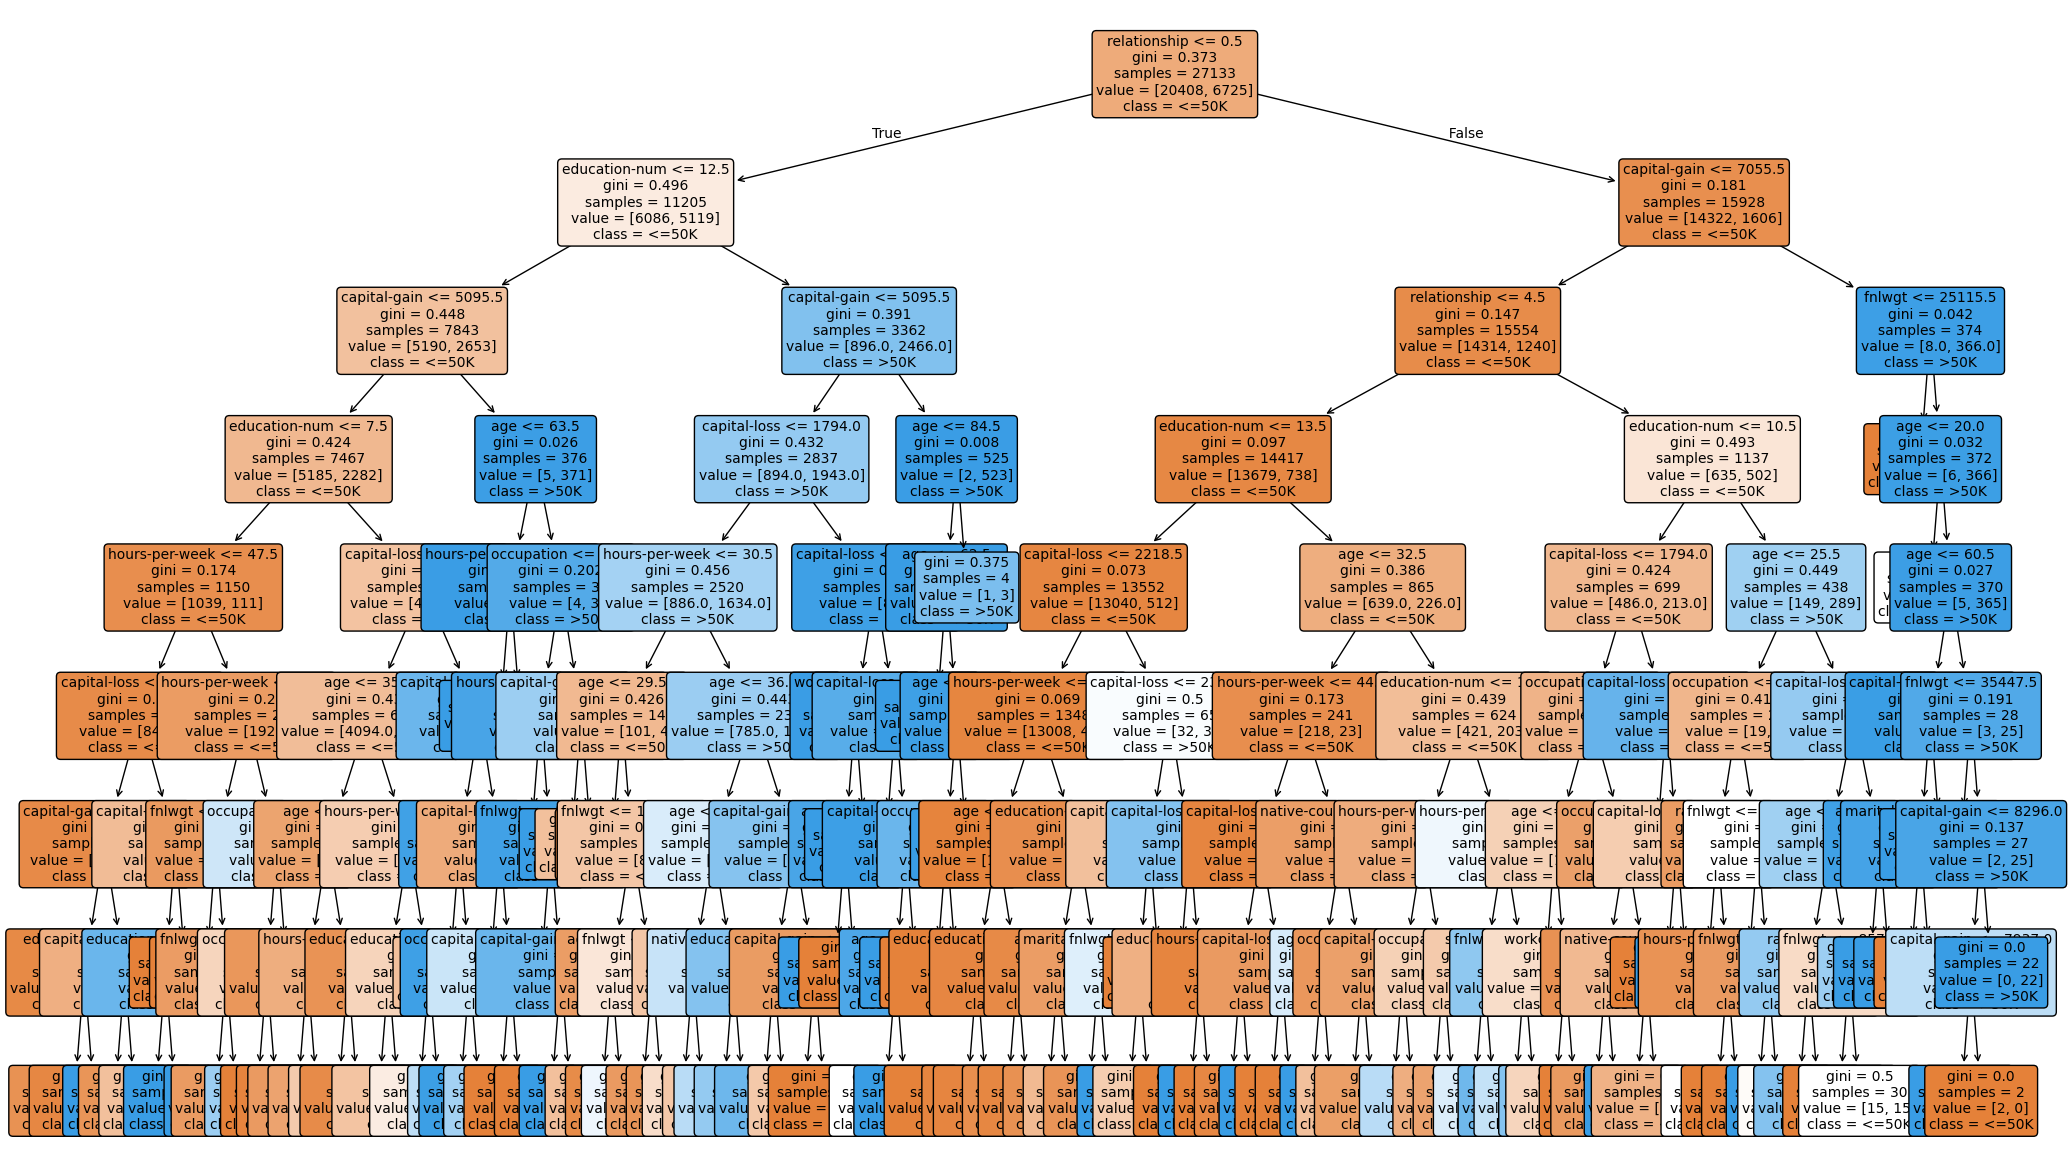

In [29]:
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTree, plot_tree
from sklearn.metrics import accuracy_score, f1_score as sklearn_f1
import matplotlib.pyplot as plt

sklearn_tree = SklearnDecisionTree(max_depth=best_depth, min_samples_split=5, random_state=42)
sklearn_tree.fit(X_train, y_train)

y_pred_sklearn = sklearn_tree.predict(X_test)

print("--- Scikit-learn Decision Tree Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_sklearn):.4f}")
print(f"F1-Score: {sklearn_f1(y_test, y_pred_sklearn):.4f}")
print()
print("--- My Implementation (Best Pre-Pruned) ---")
print(f"Accuracy: {accuracy(y_test, y_test_pred_prepruned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_prepruned):.4f}")

print("\n--- Visualizing the Scikit-learn Decision Tree ---")
plt.figure(figsize=(25, 15))
plot_tree(
    sklearn_tree,
    feature_names=feature_names,
    class_names=['<=50K', '>50K'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()



In [44]:
#HARD CODED TREE

In [45]:
def print_tree(node, feature_names, class_names, spacing=""):
    """Prints a representation of the decision tree."""

    if node is None:
        return

    if node.is_leaf_node():
        class_name = class_names[node.value]
        print(spacing + "Predict:", class_name)
        return


    feature_name = feature_names[node.feature]
    print(spacing + f"Is {feature_name} <= {node.threshold:.2f}?")


    print(spacing + '--> True:')
    print_tree(node.left, feature_names, class_names, spacing + "  ")

    print(spacing + '--> False:')
    print_tree(node.right, feature_names, class_names, spacing + "  ")


print("--- Visualizing My Custom Decision Tree (Best Pre-Pruned) ---")
print_tree(
    best_pre_pruned_tree.root,
    feature_names=feature_names,
    class_names=['<=50K', '>50K']
)


--- Visualizing My Custom Decision Tree (Best Pre-Pruned) ---
Is relationship <= 0.00?
--> True:
  Is education-num <= 12.00?
  --> True:
    Is capital-gain <= 5013.00?
    --> True:
      Is education-num <= 7.00?
      --> True:
        Is hours-per-week <= 47.00?
        --> True:
          Is capital-loss <= 1740.00?
          --> True:
            Is capital-gain <= 2885.00?
            --> True:
              Is education <= 0.00?
              --> True:
                Predict: <=50K
              --> False:
                Predict: <=50K
            --> False:
              Is capital-gain <= 3103.00?
              --> True:
                Predict: >50K
              --> False:
                Predict: <=50K
          --> False:
            Is capital-loss <= 1977.00?
            --> True:
              Is education-num <= 4.00?
              --> True:
                Predict: <=50K
              --> False:
                Predict: >50K
            --> False:
              Pr